In [75]:
reset -fs

In [76]:
#NLTK
import nltk
import nltk
nltk.download('punkt')
nltk.download('wordnet')
  
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

#Gensim
import gensim
from gensim import corpora
from gensim.models import CoherenceModel

from collections import Counter
import string

#sklearn
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer



#pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

#Other
import pandas as pd
import numpy as np
import re, string
import zipfile
import os
import matplotlib 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mariavasilenko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mariavasilenko/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data pre-processing

- Tokenization: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
- Words that have fewer than 3 characters are removed.
- All stopwords are removed.
 - Words are __lemmatized__ — words in third person are changed to first person and verbs in past and future tenses are changed into present.
- Words are __stemmed__ — words are reduced to their root form.


, 'info' , 'time'

In [616]:
# Create the list of stopwords and extend it 

stopwords = list(ENGLISH_STOP_WORDS)
# Adding "just" after running basic LDA model
newStopWords = ['just', 'like', 'love', 'good','better', 'great','easi', 'nice', 'awesom', 'thank', 'simpl',\
                'wast', 'highli', 'useless', 'conveni', 'friendli', 'finger',
                'doe', 'doesn', 'work', 'user', 'use', 'need', 'tri', 'time']
stopwords.extend(newStopWords)


def tokenize(text):
    """
    Tokenize text and return a non-unique list of tokenized words
    found in the text.
    Normalize to lowercase, strip punctuation,
    remove stop words, drop words of length < 3.
    """
    
    text=text.lower() #Convert everything to lowercase
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)  # delete stuff but leave at least a space to avoid clumping together
    words =  nltk.word_tokenize(nopunct) # tokenizing words
    words_token = [w for w in words if len(w) > 3]  # Drop words less than length 3
    words_token[:] = [w for w in words_token if w != '']
    words_stop = [w for w in words_token if w not in stopwords] # Removes stop words using SciKit-Learn's ENGLISH_STOP_WORDS set.
    words_res = [w.encode('ascii','ignore') for w in words_stop]
    return words_res

def stemwords(words):
    """
    Given a list of tokens/words, return a new list with each word
    stemmed using a PorterStemmer.
    """
    stemmer = PorterStemmer()
    words = [w.decode('ascii','ignore') for w in words]
    stemmed = [stemmer.stem(w) for w in words]
    stemmed_filtered = [w for w in stemmed if w not in stopwords]
    return stemmed_filtered

def lemmatize_stemming(words):
    words = [w.decode('ascii','ignore') for w in words]
    text = " ".join(words)
    stemmer = PorterStemmer()
    stemmed = stemmer.stem(WordNetLemmatizer().lemmatize(text))
    return stemmed.split()

def lemmatize (tokens):
    '''
    Given a list of tokens/words, return a list of lemmatized words 
    i.e. words in third person are changed to first person and verbs in past,
    and future tenses are changed into present.
    '''
    text = " ".join(tokens)
    lemmatizer = WordNetLemmatizer()
    
    return lemmatizer.lemmatize(text).split()
    
    
def tokenizer(text):
    
    return stemwords(tokenize(text))


In [617]:
len(stopwords)

343

In [618]:
df_reviews = pd.read_csv('data/appstore_googleplay_all_reviews.csv')

In [538]:
df_reviews.tail()

,name,id,title,author_name,author_uri,voteSum,voteCount,rating,text,date
6113,Google Fit: Health and Activity Tracking,com.google.android.apps.fitness,NaN,Mohit G,107526919134556209809,NaN,NaN,1,This app does not work property on my one plus...,2018-11-18 15:03:20
6114,Google Fit: Health and Activity Tracking,com.google.android.apps.fitness,NaN,sagar suryawanshi,101956979010176828886,NaN,NaN,1,I want to add leadboard How?,2018-11-18 14:54:32
6115,Medical Records App,com.cliniconline,NaN,Abod Osama,115080537418668508998,NaN,NaN,4,A great useful application but how can I trans...,2018-11-19 06:49:38
6116,Medical Records App,com.cliniconline,NaN,Agnes Novita,110614731832618616830,NaN,NaN,5,"Simple, easy, and useful",2018-11-18 03:48:23
6117,Medical Records App,com.cliniconline,NaN,Alfredo Baruc,116943082422817884463,NaN,NaN,5,Very easy to use and is what I am looking for ...,2018-11-13 05:14:25


In [539]:
# Create a dataframe with negative reviews
df_neg_reviews = df_reviews[df_reviews['rating']<=3]

In [495]:
#Create dataframe with positive reviews
df_pos_reviews = df_reviews[df_reviews['rating']>3]

In [496]:
len(df_neg_reviews)

3735

In [497]:
len(df_pos_reviews)

2383

In [498]:
assert len(df_neg_reviews) + len(df_pos_reviews) == len(df_reviews)

In [499]:
# Extract text of negative reviews
neg_reviews_text = df_neg_reviews['text']
neg_text = list(neg_reviews_text)

In [500]:
# Extract the text of positive reviews
pos_reviews_text = df_pos_reviews['text']
pos_text = list(pos_reviews_text)

In [619]:
neg_clean_text = [tokenizer(n_t) for n_t in neg_text]

In [620]:
pos_clean_text = [tokenizer(p_t) for p_t in pos_text]

In [621]:
# Adding bi-grams and tri-grams to negative reviews

from gensim.models.phrases import Phrases, Phraser
# Add bigrams and trigrams to docs (only ones that appear 10 times or more).
bigram = Phraser(Phrases(neg_clean_text, min_count=10))
trigram = Phrases(bigram[neg_clean_text])

for idx in range(len(neg_clean_text)):
    for token in bigram[neg_clean_text[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            neg_clean_text[idx].append(token)
    for token in trigram[neg_clean_text[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            neg_clean_text[idx].append(token)

In [622]:
# Adding bigrams and trigrams to positive reviews

from gensim.models.phrases import Phrases, Phraser
# Add bigrams and trigrams to docs (only ones that appear 10 times or more).
bigram = Phraser(Phrases(pos_clean_text, min_count=10))
trigram = Phrases(bigram[pos_clean_text])

for idx in range(len(pos_clean_text)):
    for token in bigram[pos_clean_text[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            pos_clean_text[idx].append(token)
    for token in trigram[pos_clean_text[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            pos_clean_text[idx].append(token)

#### Remove empty tokens

In [623]:
for item in neg_clean_text:
    item[:] = [elem for elem in item if elem != ""]


In [624]:
for item in pos_clean_text:
    item[:] = [elem for elem in item if elem != ""]


#### Create the dictionary

In [625]:
#Creating the dictionary out of corpus of negative reviews
neg_dictionary = corpora.Dictionary(neg_clean_text)

In [626]:
# Creating the dictionary out of corpus of positive reviews
pos_dictionary = corpora.Dictionary(pos_clean_text)

In [627]:
len(neg_dictionary)

3739

In [628]:
len(pos_dictionary)

2762

In [664]:
# Hyperparameters

NUM_NEG_TOPICS =5 # Number of topics in negative reviews
NUM_POS_TOPICS =5 # Number of topics in positive reviews
# PArameters used in filtering the dictionaries
MIN_DF= 2 # remove tokens that appear in less than MIN_DF docs
MAX_DF = 0.5 # Remove tokens that appear in more than MAX_DF * 100% of docs

In [665]:
# Filter extremes:
# Filter tokens that appear in less than 2 doc-s
# Filter out tokens that appear in more than 30% of docs

neg_dictionary.filter_extremes(no_below=MIN_DF, no_above= MAX_DF)
pos_dictionary.filter_extremes(no_below=MIN_DF, no_above= MAX_DF)


In [666]:
len(neg_dictionary)

2183

In [667]:
len(pos_dictionary)

1558

#### Create word term matrix

In [633]:
neg_doc_term_mx = [neg_dictionary.doc2bow(doc) for doc in neg_clean_text]

In [634]:
pos_doc_term_mx = [pos_dictionary.doc2bow(doc) for doc in pos_clean_text]

### LDA model training

In [635]:
# LDA for negative reviews

neg_lda = gensim.models.ldamodel.LdaModel(corpus=neg_doc_term_mx, \
                                      id2word=neg_dictionary, num_topics=NUM_NEG_TOPICS, random_state = 17) \
                                      #, update_every=1, chunksize=100, passes=50)

In [636]:
# LDA for positive reviews

pos_lda = gensim.models.ldamodel.LdaModel(corpus=pos_doc_term_mx, \
                                      id2word=pos_dictionary, num_topics=NUM_POS_TOPICS, random_state = 17) \
                                      #, update_every=1, chunksize=100, passes=50)

In [637]:
# Topics based on negative reviews
neg_lda.print_topics(num_words=20)

[(0,
  '0.016*"updat" + 0.015*"email" + 0.013*"doctor" + 0.013*"data" + 0.010*"messag" + 0.009*"sync" + 0.009*"latest_updat" + 0.009*"card" + 0.009*"crash" + 0.009*"test_result" + 0.009*"enter" + 0.008*"inform" + 0.007*"download" + 0.007*"send_messag" + 0.006*"info" + 0.006*"health" + 0.006*"doctor_offic" + 0.006*"login" + 0.006*"blank_screen" + 0.005*"test"'),
 (1,
  '0.019*"custom_servic" + 0.013*"card" + 0.011*"login" + 0.010*"inform" + 0.010*"custom" + 0.010*"abl" + 0.010*"password" + 0.009*"servic" + 0.008*"websit" + 0.008*"say" + 0.007*"insur" + 0.007*"issu" + 0.007*"medic" + 0.007*"help" + 0.007*"record" + 0.007*"view" + 0.007*"messag" + 0.006*"download" + 0.006*"custom_support" + 0.006*"support"'),
 (2,
  '0.021*"screen" + 0.014*"login" + 0.014*"appoint" + 0.011*"schedul_appoint" + 0.009*"look" + 0.009*"make" + 0.008*"claim" + 0.008*"load" + 0.008*"uninstal_reinstal" + 0.008*"doctor" + 0.008*"open" + 0.007*"function" + 0.007*"touch" + 0.007*"white_screen" + 0.007*"card" + 0.007

In [597]:
#Visualize negative topics
pyLDAvis.gensim.prepare(neg_lda, neg_doc_term_mx, neg_dictionary, R = 20)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.003281  0.013353       1        1  28.454458
0      0.063317  0.030963       2        1  20.559252
2      0.014262  0.043930       3        1  18.100494
3      0.027056 -0.090048       4        1  17.340775
4     -0.107917  0.001802       5        1  15.545013, topic_info=     Category        Freq                          Term       Total  loglift  \
term                                                                           
589   Default  220.000000                    insur_card  220.000000  20.0000   
831   Default  111.000000                  tech_support  111.000000  19.0000   
1393  Default  157.000000                 past_password  157.000000  18.0000   
21    Default  231.000000                          open  231.000000  17.0000   
243   Default  524.000000                      password  524.000000  16.0000   
622   Default  252.000000                 custom_servic  252.000000  15.0000   
824   Default  119.000000                  doctor_offic  119.000000  14.0000   
830   Default   85.000000                  white_screen   85.000000  13.0000   
489   Default  390.000000                        messag  390.000000  12.0000   
608   Default   77.000000             uninstal_reinstal   77.000000  11.0000   
24    Default  292.000000                         phone  292.000000  10.0000   
1881  Default   63.000000                  make_payment   63.000000   9.0000   
52    Default  241.000000                          data  241.000000   8.0000   
1500  Default  124.000000                   urgent_care  124.000000   7.0000   
1341  Default  295.000000                  error_messag  295.000000   6.0000   
372   Default  150.000000                         mobil  150.000000   5.0000   
588   Default  253.000000                         insur  253.000000   4.0000   
1436  Default   65.000000                     half_time   65.000000   3.0000   
1018  Default  139.000000                  make_appoint  139.000000   2.0000   
1536  Default   47.000000                   error_occur   47.000000   1.0000   
1869   Topic1   37.281746                       android   38.247490   1.2313   
1287   Topic1   14.760798                    forc_close   15.613394   1.2007   
1998   Topic1    9.682771                secur_question   10.459589   1.1797   
1549   Topic1    9.638644                       privaci   10.462688   1.1748   
1733   Topic1    9.141961                        height    9.951942   1.1720   
1435   Topic1   21.427837                        dollar   23.328472   1.1719   
1912   Topic1    9.126513                        corpor    9.952384   1.1702   
1724   Topic1    9.113929                          desk    9.953211   1.1688   
1673   Topic1    7.762412                  book_appoint    8.536634   1.1618   
1585   Topic1    7.758365                      programm    8.536992   1.1612   
...       ...         ...                           ...         ...      ...   
748    Topic5   40.557186                          tech   50.873917   1.6348   
1844   Topic5    5.168708                      outsourc    6.564027   1.6224   
1077   Topic5   12.791531                basic_function   16.256104   1.6217   
1393   Topic5  118.515907                 past_password  157.042633   1.5800   
1718   Topic5   29.244617                   mobil_devic   40.670918   1.5316   
1118   Topic5   24.521851                        submit   33.763481   1.5416   
1394   Topic5   14.910702  past_password_password_manag   20.979914   1.5199   
372    Topic5   73.467369                         mobil  150.103271   1.1469   
243    Topic5  184.330963                      password  524.689941   0.8154   
588    Topic5   96.553467                         insur  253.251450   0.8971   
123    Topic5   37.290409                         manag   81.949020   1.0741   
102    Topic5   17.348392                         sleep   2

- Topic 1 in pyLDA vis corresponds to Topic 4 in lda print results 
- Topic 2 in pyLDA vis corresponds to Topic 1 in lda print results 
- Topic 3 in pyLDA vis corresponds to Topic 3 in lda print results 
- Topic 4 in pyLDA vis corresponds to Topic 0 in lda print results 
- Topic 5 in pyLDA vis corresponds to Topic 2 in lda print results 

The left panel of the chart presents a global view of topics: how they are related to each other (far apart or inmtersect) and how preevalent they are (the larger the circle the more prevalent is the topic). 

THe right panel shows  the individual terms that are the most useful for interpreting the currently selected topic on the left.  A pair of overlaid bars represent both the corpus-wide frequency ofa given term as well as the topic-specific frequency of the term.

Parameter lambda regulates the _relevance_ of the term, which is used to rank terms within topics. It is regulated by parameter _lambda_.
- If _lambda_ = 1, we'll see familiar ranking of terms in decreasing order of their topic-specific probability
- If _lambda_ = 0, we'll rank words soleley by their _lift_, defined as the ratio of a term’s probability within a topic to its marginal probability across the corpus. In other words, it helps determine the words exclusivity to a particular topic. 

In [638]:
# Topics based on positive reviews
pos_lda.print_topics()

[(0,
  '0.031*"help" + 0.023*"doctor" + 0.019*"medic" + 0.015*"health" + 0.013*"record" + 0.012*"make" + 0.011*"issu" + 0.011*"commun" + 0.010*"realli" + 0.010*"inform"'),
 (1,
  '0.024*"info" + 0.015*"medic" + 0.011*"health" + 0.010*"appoint" + 0.010*"care" + 0.010*"year" + 0.009*"featur" + 0.008*"abl" + 0.008*"save" + 0.007*"medic_histori"'),
 (2,
  '0.035*"test_result" + 0.029*"medic_record" + 0.028*"inform" + 0.024*"appoint" + 0.024*"medic" + 0.022*"result" + 0.017*"doctor" + 0.017*"record" + 0.015*"abl" + 0.015*"track"'),
 (3,
  '0.021*"doctor" + 0.016*"medic" + 0.016*"doctor_offic" + 0.012*"offic" + 0.011*"help" + 0.011*"issu" + 0.011*"make" + 0.010*"inform" + 0.009*"insur_card" + 0.009*"blood_pressur"'),
 (4,
  '0.015*"health" + 0.014*"info" + 0.014*"record" + 0.013*"updat" + 0.012*"doctor" + 0.011*"access" + 0.010*"servic" + 0.010*"featur" + 0.009*"look" + 0.009*"medic"')]

In [639]:
#Visualize positive topics
pyLDAvis.gensim.prepare(pos_lda, pos_doc_term_mx, pos_dictionary, R = 20)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.073502 -0.022865       1        1  26.605637
0     -0.013227 -0.055087       2        1  20.980345
1      0.015442 -0.029200       3        1  19.288811
3     -0.043862  0.089912       4        1  18.276630
4      0.115150  0.017241       5        1  14.848582, topic_info=     Category        Freq             Term       Total  loglift  logprob
term                                                                    
11    Default  224.000000     medic_record  224.000000  20.0000  20.0000
577   Default  308.000000      test_result  308.000000  19.0000  19.0000
38    Default  272.000000             help  272.000000  18.0000  18.0000
512   Default   93.000000     doctor_offic   93.000000  17.0000  17.0000
106   Default  257.000000             info  257.000000  16.0000  16.0000
114   Default  223.000000           result  223.000000  15.0000  15.0000
383   Default  272.000000          appoint  272.000000  14.0000  14.0000
1350  Default   54.000000       insur_card   54.000000  13.0000  13.0000
111   Default   99.000000            offic   99.000000  12.0000  12.0000
1     Default   53.000000    blood_pressur   53.000000  11.0000  11.0000
206   Default   68.000000           servic   68.000000  10.0000  10.0000
46    Default  342.000000           inform  342.000000   9.0000   9.0000
284   Default   89.000000           commun   89.000000   8.0000   8.0000
804   Default   65.000000             drug   65.000000   7.0000   7.0000
81    Default  253.000000           health  253.000000   6.0000   6.0000
107   Default  166.000000             issu  166.000000   5.0000   5.0000
85    Default   81.000000            navig   81.000000   4.0000   4.0000
150   Default  172.000000            updat  172.000000   3.0000   3.0000
15    Default  286.000000           record  286.000000   2.0000   2.0000
0     Default   58.000000            blood   58.000000   1.0000   1.0000
728    Topic1    9.807728           height   10.991296   1.2101  -6.5726
11     Topic1  199.966034     medic_record  224.989044   1.2061  -3.5577
1166   Topic1   10.209414            throw   11.754844   1.1831  -6.5325
1419   Topic1    9.832870           tablet   11.400428   1.1761  -6.5701
550    Topic1   39.382549  schedul_appoint   46.015232   1.1684  -5.1825
1529   Topic1   14.620655           huawei   17.096775   1.1676  -6.1734
1005   Topic1   11.000618             stat   13.113027   1.1484  -6.4579
1446   Topic1    5.210274            prove    6.331955   1.1291  -7.2052
1549   Topic1    5.210626            lucki    6.332785   1.1290  -7.2051
1393   Topic1    5.203856            picki    6.339443   1.1267  -7.2064
...       ...         ...              ...         ...      ...      ...
582    Topic5    8.616695             imag   10.452921   1.7141  -6.1189
857    Topic5   17.434406   info_fingertip   21.250090   1.7094  -5.4142
1315   Topic5   10.483844            unabl   12.732677   1.7129  -5.9228
410    Topic5   14.165624         reinstal   18.039185   1.6655  -5.6218
779    Topic5   16.309248             sort   21.258286   1.6423  -5.4809
206    Topic5   38.008301           servic   68.358147   1.3203  -4.6348
71     Topic5   20.058784     look_forward   30.928051   1.4743  -5.2739
1105   Topic5   15.569494            treat   22.579586   1.5355  -5.5273
136    Topic5   21.146177            creat   34.596436   1.4150  -5.2211
158    Topic5   32.813484            start   64.417458   1.2327  -4.7818
69     Topic5   24.727262             ipad   43.585533   1.3404  -5.0647
832    Topic5   31.189398         password   66.879356   1.1445  -4.8325
493    Topic5   18.431925              say   30.887787   1.3910  -5.3585
134    Topic5   17.145580            carri   28.261021   1.4075  -5.4309
150    Topic5   52.850468            updat  172.072968   0.7268  -4.3051
81     Topic5   60.534363           health  253.559372   0.4749  -4.1694
98

### Coherence score

In [640]:
# Compute Coherence Score
coherence_neg_lda = CoherenceModel(model=neg_lda, texts=neg_clean_text, dictionary= neg_dictionary,  coherence='c_v')
coherence_lda = coherence_neg_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)




Coherence Score:  0.32859814998387543


In [641]:
coherence_pos_lda = CoherenceModel(model=pos_lda, texts=pos_clean_text, dictionary= pos_dictionary,  coherence='c_v')
coherence_lda = coherence_pos_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)




Coherence Score:  0.4098753368249307


In [642]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1, random_state = 17):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state = random_state)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


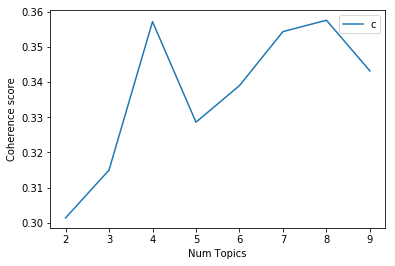

In [643]:

model_list, coherence_values = compute_coherence_values( corpus= neg_doc_term_mx, dictionary = neg_dictionary, texts = neg_clean_text, limit = 10 );
# Show graph
import matplotlib.pyplot as plt
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


Source: 
- [https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/]
- [https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/]

In [644]:
# LDA for negative reviews
NUM_NEG_TOPICS = 8
neg_lda = gensim.models.ldamodel.LdaModel(corpus=neg_doc_term_mx, \
                                      id2word=neg_dictionary, num_topics=NUM_NEG_TOPICS, random_state = 17) \
                                      #, update_every=1, chunksize=100, passes=50)
neg_lda.print_topics()

[(0,
  '0.014*"updat" + 0.014*"data" + 0.014*"sync" + 0.014*"email" + 0.012*"card" + 0.012*"doctor" + 0.011*"test_result" + 0.010*"crash" + 0.009*"enter" + 0.008*"insur_card"'),
 (1,
  '0.021*"custom_servic" + 0.020*"card" + 0.011*"custom" + 0.011*"password" + 0.011*"inform" + 0.011*"websit" + 0.010*"login" + 0.010*"messag" + 0.009*"servic" + 0.009*"custom_support"'),
 (2,
  '0.020*"screen" + 0.016*"login" + 0.013*"uninstal_reinstal" + 0.012*"card" + 0.010*"open" + 0.009*"slow" + 0.008*"look" + 0.008*"touch" + 0.008*"claim" + 0.008*"doctor"'),
 (3,
  '0.020*"updat" + 0.010*"make" + 0.010*"version" + 0.010*"urgent_care" + 0.010*"websit" + 0.009*"card" + 0.009*"doctor" + 0.008*"inform" + 0.008*"phone" + 0.008*"info"'),
 (4,
  '0.037*"password" + 0.027*"past_password" + 0.014*"past" + 0.010*"prescript" + 0.010*"phone" + 0.010*"tech_support" + 0.009*"support" + 0.009*"password_manag" + 0.008*"mobil" + 0.007*"order"'),
 (5,
  '0.013*"health_insur" + 0.013*"login" + 0.012*"white_screen" + 0.

Negative topics:

- Topic 0: insurance card, test_result. Unique words (lambda =0):  error_occur, garmin ==> TECHNICAL ISSUES: issues with SYNC, ERROR MESSAGES
- Topic 1: custom service, p/w, login==>  BAD CUSTOM SERVICE, issues with login/password
- Topic 2: screen, uninstall-reinstall. Unique words (lambda =0): uninstall/reeinstall, VIEW CLAIM  ==> VIEW CLAIMS
- Topic 3:URGENT CARE
- Topic 4:  issues with LOGIN/PASSWORD, PRESCRIPT, ORDER.  ==> PRESCRIPTIONS
- Topic 5: health insuranvce, make appointments. Unique: white screen, username/p/w
- Topic 6: messages
- Topic 7: SCHEDULE APPOINTMENTS, MAKE PAYMENTS

In [645]:
pyLDAvis.gensim.prepare(neg_lda, neg_doc_term_mx, neg_dictionary, R = 20)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.071530 -0.000013       1        1  16.358492
1     -0.027364 -0.037170       2        1  15.377185
0      0.035460 -0.002623       3        1  15.279482
5     -0.009952 -0.036897       4        1  13.303745
7      0.109872  0.025648       5        1  12.510486
2     -0.026310 -0.073928       6        1   9.726514
4     -0.052014  0.134072       7        1   9.306712
6     -0.101223 -0.009090       8        1   8.137384, topic_info=     Category        Freq               Term       Total  loglift  logprob
term                                                                      
1337  Default  312.000000       error_messag  312.000000  20.0000  20.0000
242   Default  529.000000           password  529.000000  19.0000  19.0000
1389  Default  163.000000      past_password  163.000000  18.0000  18.0000
621   Default  237.000000      custom_servic  237.000000  17.0000  17.0000
558   Default  123.000000    schedul_appoint  123.000000  16.0000  16.0000
829   Default   87.000000       white_screen   87.000000  15.0000  15.0000
147   Default  286.000000             screen  286.000000  14.0000  14.0000
1495  Default  130.000000        urgent_care  130.000000  13.0000  13.0000
607   Default   68.000000  uninstal_reinstal   68.000000  12.0000  12.0000
48    Default  176.000000               sync  176.000000  11.0000  11.0000
1262  Default  122.000000       health_insur  122.000000  10.0000  10.0000
406   Default  116.000000       latest_updat  116.000000   9.0000   9.0000
584   Default  453.000000               card  453.000000   8.0000   8.0000
830   Default  106.000000       tech_support  106.000000   7.0000   7.0000
1876  Default   65.000000       make_payment   65.000000   6.0000   6.0000
319   Default   86.000000   usernam_password   86.000000   5.0000   5.0000
588   Default  207.000000         insur_card  207.000000   4.0000   4.0000
711   Default   79.000000     custom_support   79.000000   3.0000   3.0000
250   Default  212.000000               past  212.000000   2.0000   2.0000
1388  Default   86.000000     password_manag   86.000000   1.0000   1.0000
1283   Topic1   14.477130         forc_close   15.499115   1.7422  -6.4044
1229   Topic1    9.042330         step_count    9.888096   1.7210  -6.8750
1893   Topic1    9.041970             faster    9.888058   1.7210  -6.8751
1907   Topic1    9.039809             corpor    9.888118   1.7207  -6.8753
1909   Topic1    9.039886         particular    9.888265   1.7207  -6.8753
1470   Topic1    8.138912              handl    8.988710   1.7111  -6.9803
1610   Topic1    7.638776            distanc    8.484169   1.7055  -7.0437
1852   Topic1    7.637236             unhelp    8.484321   1.7052  -7.0439
1580   Topic1    7.634072           programm    8.484365   1.7048  -7.0443
1453   Topic1    6.233532         jailbroken    7.080290   1.6831  -7.2470
...       ...         ...                ...         ...      ...      ...
1627   Topic8    2.054045            nicknam    3.091555   2.0998  -7.6588
1368   Topic8   36.324066     reset_password   57.393925   2.0512  -4.7862
1337   Topic8  175.392853       error_messag  312.373962   1.9315  -3.2116
1248   Topic8    6.827211              stand   11.498335   1.9874  -6.4577
406    Topic8   43.836811       latest_updat  116.573639   1.5307  -4.5982
604    Topic8   21.120836              reset   48.207680   1.6834  -5.3284
82     Topic8   58.551842               site  174.428802   1.4171  -4.3087
535    Topic8   14.344742             direct   32.423164   1.6932  -5.7153
1708   Topic8    6.366319       desktop_site   11.563692   1.9119  -6.5276
330    Topic8   68.978111              error  269.490479   1.1460  -4.1449
488    Topic8   85.721039             messag  396.648895   0.9767  -3.9276
635    Topic8   26.832928              googl   86.778831   1.3350  -5.0890
242    Topic8   90.404366           passwo

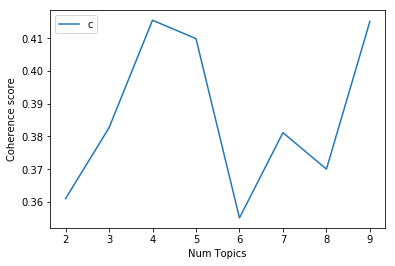

In [646]:
#Positive reviews coherence score

model_list, coherence_values = compute_coherence_values( corpus= pos_doc_term_mx, dictionary = pos_dictionary, texts = pos_clean_text, limit = 10 );
# Show graph
import matplotlib.pyplot as plt
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show();


In [649]:
# LDA for positive reviews
NUM_POS_TOPICS = 9
pos_lda = gensim.models.ldamodel.LdaModel(corpus=pos_doc_term_mx, \
                                      id2word=pos_dictionary, num_topics=NUM_POS_TOPICS, random_state = 17) \
                                      #, update_every=1, chunksize=100, passes=50)

In [650]:
pos_lda.print_topics(20)

[(0,
  '0.035*"help" + 0.028*"medic" + 0.024*"doctor" + 0.013*"health" + 0.013*"inform" + 0.013*"make" + 0.012*"issu" + 0.012*"record" + 0.011*"realli" + 0.010*"note"'),
 (1,
  '0.027*"info" + 0.026*"medic" + 0.014*"phone" + 0.011*"test_result" + 0.011*"medic_histori" + 0.011*"doctor" + 0.011*"access" + 0.010*"abl" + 0.009*"histori" + 0.009*"care"'),
 (2,
  '0.039*"inform" + 0.038*"medic_record" + 0.029*"medic" + 0.025*"appoint" + 0.020*"doctor" + 0.019*"abl" + 0.019*"record" + 0.019*"test_result" + 0.017*"track" + 0.011*"result"'),
 (3,
  '0.025*"doctor" + 0.019*"doctor_offic" + 0.017*"medic" + 0.016*"help" + 0.015*"insur_card" + 0.013*"make" + 0.012*"offic" + 0.012*"inform" + 0.010*"updat" + 0.010*"blood_pressur"'),
 (4,
  '0.017*"info" + 0.015*"navig" + 0.014*"sure" + 0.012*"doctor" + 0.011*"health" + 0.011*"servic" + 0.010*"scroll" + 0.008*"account" + 0.008*"lot" + 0.007*"medic"'),
 (5,
  '0.020*"track" + 0.018*"result" + 0.017*"test_result" + 0.013*"activ" + 0.012*"look" + 0.010*"

__Suggested topics based on positive reviews__
- Topic 0 (2): health information. Exclusive words:  chronic, treatment ==> FEATURE: access to  HEALTH INFO, TREATMENT
- Topic 1 (6): TEST RESULTS,  MEDICAL HISTORY
- Topic 2 (1):medical record, doctor appointments. Esclusive: MEDICAL RECORD ==> DOCTOR APPOINTMENTS , MEDICAL RECORD
- Topic 3 (4): doctor, doctor_office, insurance card. Exclusive: insur card. ==> FEAUTURE: in-app Insurance card info?
- Topic 4 (9): easy to navigate, medical records ==> access to MEDICAL RECORDS
- Topic 5 (8): tracl, test results. Exclusive: sleep, exercise, trust. ==> FEAUTURE: TEST RESULTS, TRACKING SLEEP and EXERCISE
- Topic 6 (5): doctor, save, drug, message, send message. Exclusive: distance, code, regist. ==> FEAUTURE: MESSAGING to DOCTOR
- Topic 7 (7): test result,m appoint, refill prescription. Esxclusive: blood sugar, heart rate ==> Feature: REFILL PRESCRIPTION, HEART RATE, TEST RESULTS (blood sugar, radiology)
- Topic 8 (3): similar



In [651]:
#Visualize positive topics
pyLDAvis.gensim.prepare(pos_lda, pos_doc_term_mx, pos_dictionary, R = 20)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.092100 -0.002303       1        1  17.495342
0      0.029814  0.078038       2        1  15.205291
8      0.016992 -0.053322       3        1  11.314408
3      0.028897  0.045882       4        1  11.164272
6     -0.010440  0.072286       5        1  10.906917
1      0.009828  0.008493       6        1  10.711196
7      0.048682 -0.093355       7        1   7.970893
5     -0.078177 -0.083853       8        1   7.762924
4     -0.137696  0.028133       9        1   7.468761, topic_info=     Category        Freq             Term       Total  loglift  logprob
term                                                                    
577   Default  330.000000      test_result  330.000000  20.0000  20.0000
11    Default  234.000000     medic_record  234.000000  19.0000  19.0000
38    Default  286.000000             help  286.000000  18.0000  18.0000
512   Default  100.000000     doctor_offic  100.000000  17.0000  17.0000
106   Default  244.000000             info  244.000000  16.0000  16.0000
114   Default  238.000000           result  238.000000  15.0000  15.0000
383   Default  279.000000          appoint  279.000000  14.0000  14.0000
1350  Default   58.000000       insur_card   58.000000  13.0000  13.0000
46    Default  353.000000           inform  353.000000  12.0000  12.0000
33    Default  228.000000            track  228.000000  11.0000  11.0000
804   Default   64.000000             drug   64.000000  10.0000  10.0000
85    Default   83.000000            navig   83.000000   9.0000   9.0000
652   Default   54.000000            activ   54.000000   8.0000   8.0000
15    Default  286.000000           record  286.000000   7.0000   7.0000
298   Default  110.000000             save  110.000000   6.0000   6.0000
1292  Default   70.000000  refil_prescript   70.000000   5.0000   5.0000
1     Default   55.000000    blood_pressur   55.000000   4.0000   4.0000
217   Default   53.000000      send_messag   53.000000   3.0000   3.0000
0     Default   60.000000            blood   60.000000   2.0000   2.0000
54    Default   62.000000             sure   62.000000   1.0000   1.0000
728    Topic1   10.070981           height   11.228389   1.6344  -6.1270
1419   Topic1   10.073503           tablet   11.662974   1.5967  -6.1267
1319   Topic1   10.453503       mail_order   12.397567   1.5727  -6.0897
1404   Topic1    5.287137         altogeth    6.440998   1.5458  -6.7714
1549   Topic1    5.287080            lucki    6.440994   1.5458  -6.7714
1499   Topic1    5.285777            fault    6.441321   1.5455  -6.7716
634    Topic1    5.284893           surgic    6.441718   1.5453  -6.7718
1395   Topic1    5.284601           deeper    6.441812   1.5452  -6.7718
1545   Topic1    5.106956           tonsil    6.468043   1.5070  -6.8060
791    Topic1    5.384721       seamlessli    6.870280   1.4996  -6.7531
...       ...         ...              ...         ...      ...      ...
1059   Topic9    7.105350            weren    8.417844   2.4249  -5.6246
1430   Topic9    7.330535         uninstal    8.874562   2.4033  -5.5934
266    Topic9    7.126607          lifesav    8.867314   2.3759  -5.6216
1130   Topic9    7.002401            white    8.844812   2.3609  -5.6392
858    Topic9    7.332381            sourc    9.314799   2.3551  -5.5931
1315   Topic9    9.314075            unabl   11.838417   2.3546  -5.3539
772    Topic9    6.395463          convinc    8.280342   2.3361  -5.7298
1180   Topic9    7.332633          usernam    9.734924   2.3111  -5.5931
809    Topic9    7.485061           forgot   10.083839   2.2964  -5.5725
1377   Topic9    7.332556           prefer   10.194842   2.2649  -5.5931
92     Topic9    6.922391             flaw    9.627488   2.2646  -5.6507
668    Topic9    7.224232             beat   10.059601   2.2634  -5.6080
776    Topic9   14.953912              lot   25.425510   2.0637  -4.8805
961  